In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import glob, os

os.chdir('../core')
import stitching_ssid as ssid

os.chdir('../../../../pyRRHDLDS/core')
import ssm_scripts

import pprint

# Covariance matrix completion 
- $\mbox{cov}(y) = C C^\top$
- if cov($y$) has missing off-diagonal blocks, parts of $C$ are underdetermined (change of latent basis)
- Bishop et al. (2014) introduced a basic algorithm for rotating latent bases based on overlap
- Srini had the idea to just learn all chunks of C at the same time using gradient descent

In [ ]:
def f(C,A,Q,Om):
    v = (C.dot(A.dot(C.T)))[Om] - Q[Om]
    return v.dot(v.T)

def g(C,A,Q,idx_grp, obs_idx):
    
    p,n = C.shape
    
    grad = np.zeros((p,n))
    for i in range(len(idx_grp)):
        
        def co_observed(x):
            for idx in obs_idx:
                if x in idx and i in idx:
                    return True
            return False
                
        co_obs_i = [idx_grp[item] for item in np.arange(len(idx_grp)) if co_observed(item)]
        co_obs_i = np.sort(np.hstack(co_obs_i))
        
        grad[idx_grp[i],:] = g_idxgrp(C,A,Q,idx_grp[i],co_obs_i)
        
    return grad

def g_idxgrp(C,A,Q,idx_grp_i,co_obs_i):
    Cc, CcT = C[co_obs_i,:].dot(A), C[co_obs_i,:].dot(A.T) 
    Ci, Qic = C[idx_grp_i,:], Q[np.ix_(idx_grp_i, co_obs_i)]
     
    return (Ci.dot(Cc.T) - Qic).dot(Cc) + (Ci.dot(CcT.T) - Qic).dot(CcT)

"""
def f(C,Q,Om):
    v = (C.dot(C.T)[Om] - Q[Om])
    return v.dot(v.T)

def g(C,Q,idx_grp, obs_idx):
    
    p,n = C.shape
    
    grad = np.zeros((p,n))
    for i in range(len(idx_grp)):
        
        def co_observed(x):
            for idx in obs_idx:
                if x in idx and i in idx:
                    return True
            return False
                
        co_obs_i = [idx_grp[item] for item in np.arange(len(idx_grp)) if co_observed(item)]
        co_obs_i = np.sort(np.hstack(co_obs_i))
        
        grad[idx_grp[i],:] = g_idxgrp(C,Q,idx_grp[i],co_obs_i)
        
    return grad

def g_idxgrp(C,Q,idx_grp_i,co_obs_i):
    Cc, Ci, Qic = C[co_obs_i,:], C[idx_grp_i,:], Q[np.ix_(idx_grp_i, co_obs_i)]
     
    return (Ci.dot(Cc.T) - Qic).dot(Cc) #- np.diag(np.sum(Ci*Ci,axis=1)-Q[idx_grp_i,idx_grp_i]).dot(Ci)
#    return (Ci.dot(Cc.T) - Qic).dot(Cc) - (np.sum(Ci*Ci,axis=1)-Q[idx_grp_i,idx_grp_i]) * Ci
"""

p,n = 11,2

# create subpopulations
sub_pops = (np.arange(0,5), np.arange(3,8), np.arange(6,p))
print('sub_pops', sub_pops)

Om = np.zeros((p,p), dtype=bool)
for i in range(len(sub_pops)):
    Om[np.ix_(sub_pops[i],sub_pops[i])] = True

obs_idx, idx_grp = ssid.get_obs_index_groups(obs_scheme={'sub_pops': sub_pops,'obs_pops': (0,1,2)},p=p)

print('idx_grp:', idx_grp)
print('obs_idx:', obs_idx)

for rep in range(10):
    
    C_true = np.random.normal(size=(p,n))
    Q_true = C_true.dot(C_true.T)
    Q_obs = Q_true * np.asarray( Om, dtype=int)
    Q_sti = Q_true * np.asarray(~Om, dtype=int)
    APi = np.eye(n)
    
    C_0 = np.random.normal(size=(p,n))
    C_est = C_0.copy()
    max_iter, a= 100000, 0.001
    err_obs, err_sti  = np.empty(max_iter), np.empty(max_iter)
    for t in range(max_iter):
        
            if np.mod(t,20000)==0:
                a /= 2
                
            C_est -= a * g(C_est, APi, Q_obs, idx_grp, obs_idx)
            err_obs[t] = f(C_est, APi, Q_obs, Om)
            err_sti[t] = f(C_est, APi, Q_sti,~Om)

    print('final squared error on observed parts:', err_obs[-1])

    plt.figure(figsize=(20,7))
    plt.subplot(1,4,1)
    plt.plot(err_obs[t//4:])
    plt.hold(True)
    plt.plot(err_sti[t//4:])
    plt.xlabel('iteration')
    plt.ylabel('SE on observed parts of matrix')
    plt.title('Squared error')
    plt.subplot(1,4,2)
    plt.imshow(C_0.dot(C_0.T),interpolation='none')
    plt.title('Initial matrix (C_0 C_0^T)')
    plt.subplot(1,4,3)
    plt.imshow(C_est.dot(C_est.T),interpolation='none')
    plt.title('Estimated matrix')
    plt.subplot(1,4,4)
    plt.imshow(Q_true,interpolation='none')
    plt.title('True  matrix')
    plt.show()



# Hankel covariance matrix completion 
- $ H_{k,l} = (I_k \otimes C) H^{xx}_{k,l} (I_k \otimes C)^\top $
- $ H^{xx}_{k,l} = \left[\begin{array}{llll} A \Pi & A^2 \Pi & \ldots & A^l \Pi\\ A^2 \Pi & A^3 \Pi & \ldots & A^{l+1} \Pi\\ \vdots & \vdots & \ddots & \vdots \\ A^{k} \Pi & A^{k+1} \Pi & \ldots & A^{k+l-1} \Pi \end{array} \right] $
- if cov($x$) has missing off-diagonal blocks, parts of $C$ are underdetermined (change of latent basis)
- each block of the Hankel cov matrix $H_{k,l}$ exhibits the same structure of missing entries as does cov($y$.
- We can combine the overlaps of the $k \times l$ many blocks of $H_{k,l}$ when collecting constraints on the latent basis.
- We here assume $A,\Pi$ to be known, and apply Srini's idea of joint gradient descent on the whole $C$ to $H_{k,l}$

sub_pops (array([0, 1, 2]), array([2, 3, 4]))
idx_grp: [array([0, 1]), array([3, 4]), array([2])]
obs_idx: [[0, 2], [1, 2]]
final squared error on observed parts: 2.75959615747e-06


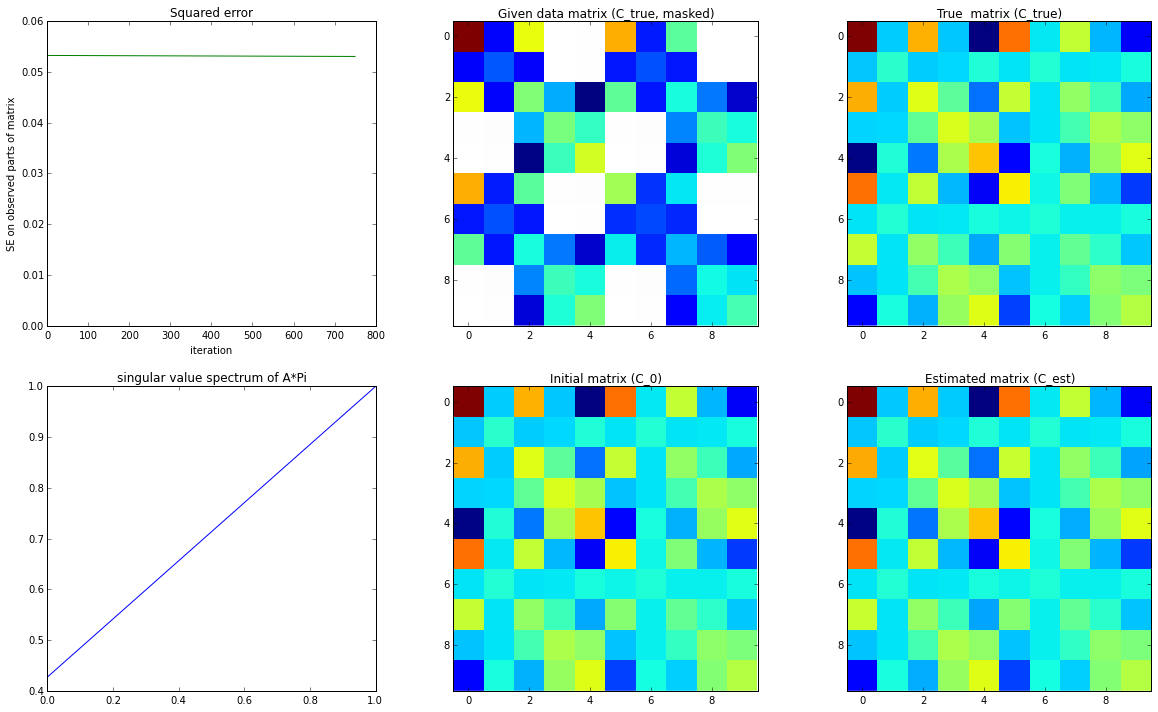

In [139]:
def xx_Hankel_cov_mat(A,Pi,k,l):
    
    n = A.shape[0]
    assert n == A.shape[1] and n == Pi.shape[0] and n == Pi.shape[1]
    
    H = np.zeros((k*n, l*n))
    print(H.shape)
    
    for kl_ in range(k+l-1):        
        lamK = np.linalg.matrix_power(A,kl_+1).dot(Pi)
        if kl_ < k-0.5:     
            for l_ in range(0, min(kl_ + 1,l)):
                offset0, offset1 = (kl_-l_)*n, l_*n
                H[offset0:offset0+n, offset1:offset1+n] = lamK
                
        else:
            for l_ in range(0, min(k+l - kl_ -1, l, k)):
                offset0, offset1 = (k - l_ - 1)*n, ( l_ + kl_ + 1 - k)*n
                H[offset0:offset0+n,offset1:offset1+n] = lamK
            
    return H

def yy_Hankel_cov_mat(C,A,Pi,k,l,Om=None):
    
    p,n = C.shape
    assert n == A.shape[1] and n == Pi.shape[0] and n == Pi.shape[1]
    
    assert (Om is None) or (Om.shape == (p,p))
    
    H = np.zeros((k*p, l*p))
    
    for kl_ in range(k+l-1):        
        lamK = (C.dot(np.linalg.matrix_power(A,kl_+1).dot(Pi))).dot(C.T)
        
        lamK = lamK if Om is None else lamK * np.asarray( Om, dtype=float) 
        if kl_ < k-0.5:     
            for l_ in range(0, min(kl_ + 1,l)):
                offset0, offset1 = (kl_-l_)*p, l_*p
                H[offset0:offset0+p, offset1:offset1+p] = lamK
                
        else:
            for l_ in range(0, min(k+l - kl_ -1, l, k)):
                offset0, offset1 = (k - l_ - 1)*p, ( l_ + kl_ + 1 - k)*p
                H[offset0:offset0+p,offset1:offset1+p] = lamK
            
    return H

def f_Hankel(C,A,Pi,k,l,Qs, Om):
    
    err = 0.
    for k_ in range(k):
        for l_ in range(l):
            APi = np.linalg.matrix_power(A, k_+l_ + 1).dot(Pi)  
            err += f(C,APi,Qs[k_+l_],Om)
            
    return err
    
def f(C,A,Q,Om):
    v = (C.dot(A.dot(C.T)))[Om] - Q[Om]
    return v.dot(v.T)

def g(C,A,Pi,k,l,Qs,idx_grp, obs_idx):
    
    p,n = C.shape
    
    grad = np.zeros((p,n))
    for i in range(len(idx_grp)):
        
        def co_observed(x):
            for idx in obs_idx:
                if x in idx and i in idx:
                    return True
            return False
                
        co_obs_i = [idx_grp[item] for item in np.arange(len(idx_grp)) if co_observed(item)]
        co_obs_i = np.sort(np.hstack(co_obs_i))
        
        for k_ in range(k):
            for l_ in range(l):
                APi = np.linalg.matrix_power(A, k_+l_ + 1).dot(Pi)                
                grad[idx_grp[i],:] += g_idxgrp(C,APi,Qs[k_+l_],idx_grp[i],co_obs_i)
        
    return grad

def g_idxgrp(C,A,Q,idx_grp_i,co_obs_i):
    Cc, CcT = C[co_obs_i,:].dot(A), C[co_obs_i,:].dot(A.T) 
    Ci, Qic = C[idx_grp_i,:], Q[np.ix_(idx_grp_i, co_obs_i)]
     
    return (Ci.dot(Cc.T) - Qic).dot(Cc) + (Ci.dot(CcT.T) - Qic).dot(CcT)

p,n = 6,2

# create subpopulations
sub_pops = (np.arange(0,4), np.arange(2,p))
print('sub_pops', sub_pops)

Om = np.zeros((p,p), dtype=bool)
for i in range(len(sub_pops)):
    Om[np.ix_(sub_pops[i],sub_pops[i])] = True

obs_idx, idx_grp = ssid.get_obs_index_groups(obs_scheme={'sub_pops': sub_pops,'obs_pops': (0,1)},p=p)

print('idx_grp:', idx_grp)
print('obs_idx:', obs_idx)

for rep in range(1):
    
    C_true = np.random.normal(size=(p,n))
    Pi     = np.random.normal(size=(n,20))/20
    Pi     = Pi.dot(Pi.T)  + 0.1 * np.eye(n)
    A      = np.diag([0.6, 0.8]) #np.random.normal(size=(n,n))    
    APi    = A.dot(Pi)
    k,l = 1,1
    Qs = []
    for kl_ in range(k+l-1):
        Akl = np.linalg.matrix_power(A, kl_+1)
        Qs.append(C_true.dot(Akl.dot(Pi)).dot(C_true.T) *np.asarray( Om,dtype=int) )        
    Q_obs = Qs[0].copy()
    Q_sti = C_true.dot(APi.dot(C_true.T))*np.asarray(~Om,dtype=int)
    H_true = yy_Hankel_cov_mat(C_true,A,Pi,k,l)
    H_obs = yy_Hankel_cov_mat(C_true,A,Pi,k,l, Om)
    H_obs[np.where(H_obs==0)] = np.nan
    H_sti = yy_Hankel_cov_mat(C_true,A,Pi,k,l,~Om)
    
    C_0 = C_true # np.random.normal(size=(p,n))
    C_est = C_0.copy()
    max_iter, a= 1000, 0.01
    err_obs, err_sti  = np.empty(max_iter), np.empty(max_iter)
    for t in range(max_iter):
        
            if np.mod(t,10000)==0:
                a /= 2
                
            C_est -= a * g(C_est, A, Pi, k, l, Qs, idx_grp, obs_idx)
            err_obs[t] = f_Hankel(C_est, A, Pi, k, l, Qs, Om)
            err_sti[t] = f_Hankel(C_est, A, Pi, k, l, Qs,~Om)

    print('final squared error on observed parts:', err_obs[-1])

    plt.figure(figsize=(20,12))
    plt.subplot(2,3,1)
    plt.plot(err_obs[t//4:])
    plt.hold(True)
    plt.plot(err_sti[t//4:])
    plt.xlabel('iteration')
    plt.ylabel('SE on observed parts of matrix')
    plt.title('Squared error')
    plt.subplot(2,3,4)
    _,s,_ = np.linalg.svd(APi)
    plt.plot(np.cumsum(np.sort(s))/np.sum(s))
    plt.title('singular value spectrum of A*Pi')    

    plt.subplot(2,3,2)
    tmp = yy_Hankel_cov_mat(C_true,A,Pi,k,l,Om)
    tmp[np.where(tmp==0)] = np.nan
    plt.imshow(tmp,interpolation='none')
    plt.title('Given data matrix (C_true, masked)')
    plt.subplot(2,3,3)
    plt.imshow(yy_Hankel_cov_mat(C_true,A,Pi,k,l),interpolation='none')
    plt.title('True  matrix (C_true)')
    
    plt.subplot(2,3,5)
    plt.imshow(yy_Hankel_cov_mat(C_0,A,Pi,k,l),interpolation='none')
    plt.title('Initial matrix (C_0)')
    plt.subplot(2,3,6)
    plt.imshow(yy_Hankel_cov_mat(C_est,A,Pi,k,l),interpolation='none')
    plt.title('Estimated matrix (C_est)')
    plt.show()
